## Compare compressed vs. raw results

In this notebook, we want to compare mutation status classification results with varying numbers of PCA components as predictors against results with raw features (standardized CpG beta values for methylation data, standardized per-gene expression values for RNA-seq data).

Notebook parameters:
* SIG_ALPHA (float): significance cutoff after FDR correction
* PLOT_AUROC (bool): if True plot AUROC, else plot AUPR

In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from adjustText import adjust_text

import mpmp.config as cfg
import mpmp.utilities.analysis_utilities as au

%load_ext autoreload
%autoreload 2

In [2]:
# set results directories
results_dir = Path(cfg.results_dirs['mutation'],
                   'merged_methylation',
                   'gene').resolve()
extra_results_dir = Path(cfg.results_dirs['mutation'],
                   'methylation_dims',
                   'gene').resolve()

# set significance cutoff after FDR correction
SIG_ALPHA = 0.001

# if True, save figures to ./images directory
SAVE_FIGS = True

# if True, plot AUROC instead of AUPR
PLOT_AUROC = False
if PLOT_AUROC:
    plot_metric = 'auroc'
    images_dir = Path(cfg.images_dirs['mutation'], 'auroc')
else:
    plot_metric = 'aupr'
    images_dir = Path(cfg.images_dirs['mutation'])

In [3]:
# load raw data
raw_results_df = au.load_stratified_prediction_results(results_dir, 'gene')

print(raw_results_df.shape)
print(raw_results_df.seed.unique())
print(raw_results_df.training_data.unique())
raw_results_df.head()

(13032, 9)
[42  1]
['expression']


,auroc,aupr,identifier,training_data,signal,seed,data_type,fold,experiment
0,0.99962,0.99578,MAP3K1,expression,signal,42,train,0,gene
1,0.61241,0.17782,MAP3K1,expression,signal,42,test,0,gene
2,0.68779,0.24224,MAP3K1,expression,signal,42,cv,0,gene
3,0.98210,0.87136,MAP3K1,expression,signal,42,train,1,gene
4,0.74268,0.37469,MAP3K1,expression,signal,42,test,1,gene


In [4]:
# load raw data
extra_raw_results_df = au.load_stratified_prediction_results(extra_results_dir, 'gene')

print(extra_raw_results_df.shape)
print(extra_raw_results_df.seed.unique())
print(extra_raw_results_df.training_data.unique())
extra_raw_results_df.head()

(26064, 9)
[42  1]
['me_450k' 'me_27k']


,auroc,aupr,identifier,training_data,signal,seed,data_type,fold,experiment
0,1.00000,1.00000,MAP3K1,me_450k,signal,42,train,0,gene
1,0.62787,0.22402,MAP3K1,me_450k,signal,42,test,0,gene
2,0.64314,0.19300,MAP3K1,me_450k,signal,42,cv,0,gene
3,1.00000,1.00000,MAP3K1,me_450k,signal,42,train,1,gene
4,0.60701,0.18919,MAP3K1,me_450k,signal,42,test,1,gene


In [5]:
raw_results_df = pd.concat((
    raw_results_df, extra_raw_results_df
))
group_df = (raw_results_df
    .groupby(['identifier', 'training_data'])
    .count()
)

# all of these should come up as duplicates (so only one row will print)
# if not, there are either missing folds or duplicated folds
group_df[~group_df.duplicated()].head(10)

,,auroc,aupr,signal,seed,data_type,fold,experiment
identifier,training_data,,,,,,,
ABL1,expression,48,48,48,48,48,48,48
UNCX,expression,24,24,24,24,24,24,24


In [6]:
# load compressed data
compressed_results_df = au.load_compressed_prediction_results(results_dir, 'gene')

print(compressed_results_df.shape)
print(compressed_results_df.seed.unique())
print(compressed_results_df.n_dims.unique())
print(compressed_results_df.training_data.unique())
compressed_results_df.head()

(26064, 10)
[ 1 42]
[5000]
['me_450k' 'me_27k']


,auroc,aupr,identifier,training_data,signal,seed,data_type,fold,n_dims,experiment
0,1.00000,1.00000,MAP3K1,me_450k,signal,1,train,0,5000,gene
1,0.60644,0.17261,MAP3K1,me_450k,signal,1,test,0,5000,gene
2,0.62170,0.24357,MAP3K1,me_450k,signal,1,cv,0,5000,gene
3,1.00000,1.00000,MAP3K1,me_450k,signal,1,train,1,5000,gene
4,0.58918,0.23904,MAP3K1,me_450k,signal,1,test,1,5000,gene


In [7]:
# load compressed data
extra_compressed_results_df = au.load_compressed_prediction_results(
    extra_results_dir, 'gene')

print(extra_compressed_results_df.shape)
print(extra_compressed_results_df.seed.unique())
print(extra_compressed_results_df.training_data.unique())
extra_compressed_results_df.head()

(91224, 10)
[ 1 42]
['expression' 'me_27k' 'me_450k']


,auroc,aupr,identifier,training_data,signal,seed,data_type,fold,n_dims,experiment
0,0.74074,0.200390,MAP3K1,expression,shuffled,1,train,0,1000,gene
1,0.49608,0.062626,MAP3K1,expression,shuffled,1,test,0,1000,gene
2,0.52033,0.100500,MAP3K1,expression,shuffled,1,cv,0,1000,gene
3,0.89517,0.317880,MAP3K1,expression,shuffled,1,train,1,1000,gene
4,0.49404,0.101610,MAP3K1,expression,shuffled,1,test,1,1000,gene


In [8]:
compressed_results_df = pd.concat((
    compressed_results_df, extra_compressed_results_df
))
group_df = (compressed_results_df
    .groupby(['identifier', 'training_data'])
    .count()
)

# all of these should come up as duplicates (so only one row will print)
# if not, there are either missing folds or duplicated folds
group_df[~group_df.duplicated()].head(10)

,,auroc,aupr,signal,seed,data_type,fold,n_dims,experiment
identifier,training_data,,,,,,,,
ABL1,expression,144,144,144,144,144,144,144,144
UNCX,expression,72,72,72,72,72,72,72,72


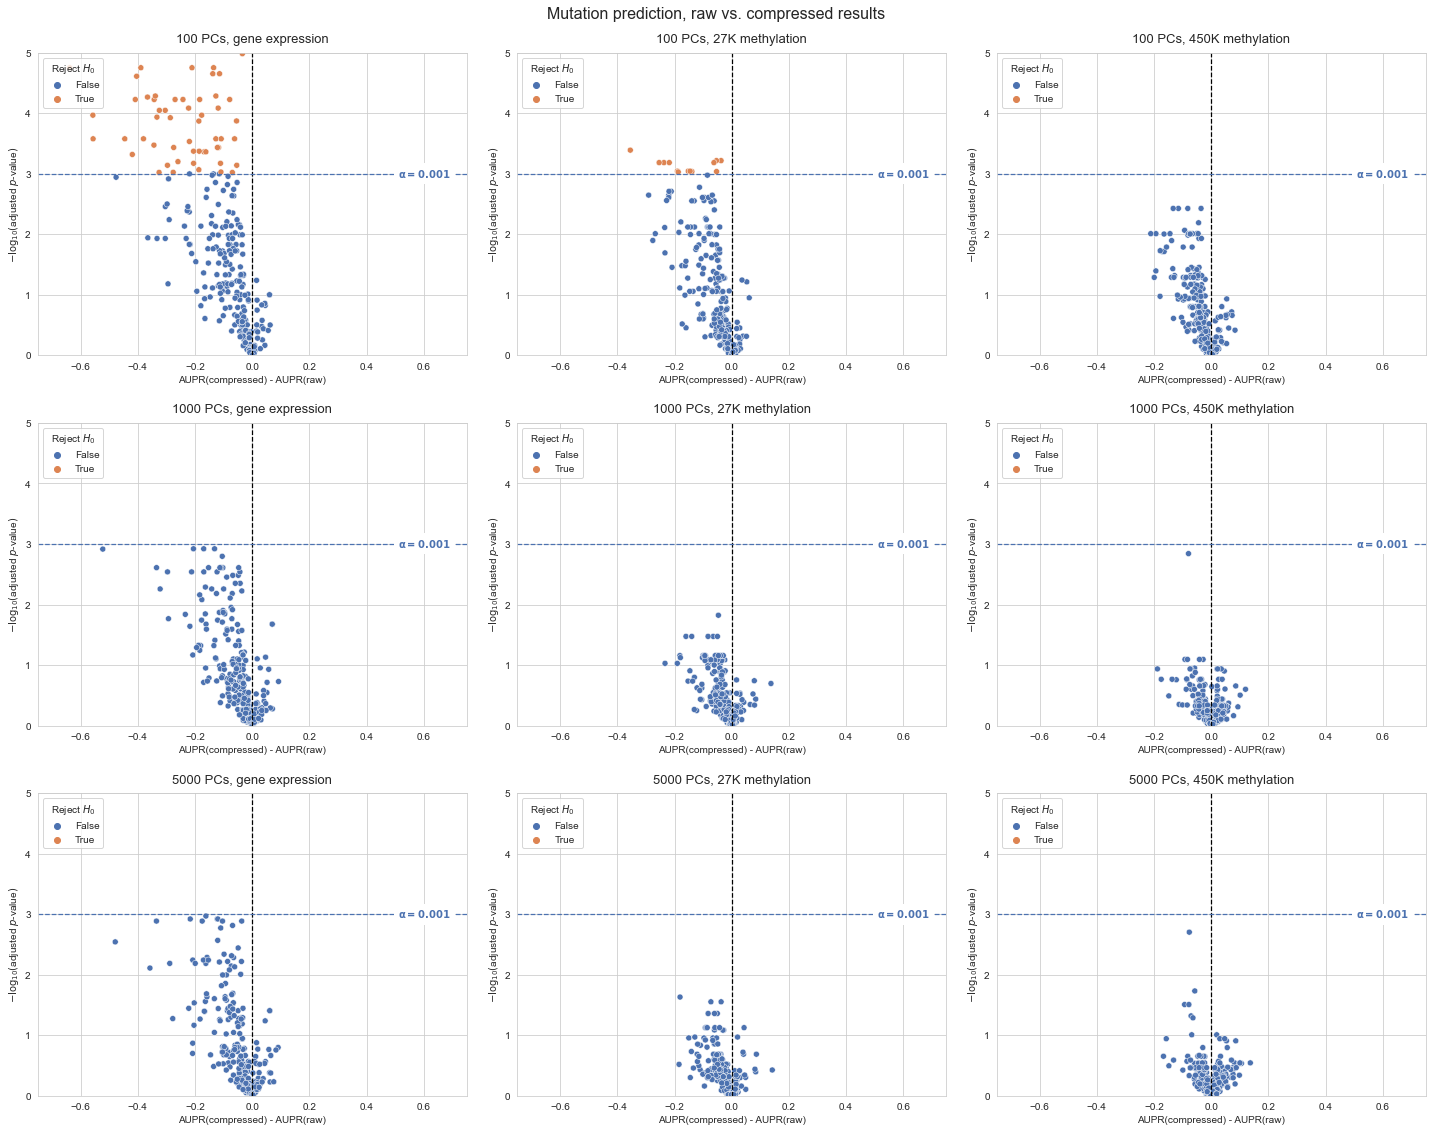

In [9]:
def label_points(x, y, gene, sig, ax):
    text_labels = []
    a = pd.DataFrame({'x': x, 'y': y, 'gene': gene, 'sig': sig})
    for i, point in a.iterrows():
        if point['y'] > 1.0 or abs(point['x']) > 0.2:
            text_labels.append(
                ax.text(point['x'], point['y'], str(point['gene']))
            )
    return text_labels

# plot comparisons for all pairwise combinations of training datasets,
# within each choice of compression dimension
import itertools as it

sns.set({'figure.figsize': (20, 16)})
sns.set_style('whitegrid')
fig, axarr = plt.subplots(3, 3)

raw_results_df.sort_values(by=['training_data'], inplace=True)
compressed_results_df.sort_values(by=['n_dims', 'training_data'], inplace=True)
for row_ix, n_dims in enumerate(compressed_results_df.n_dims.unique()):
    for col_ix, train_data in enumerate(compressed_results_df.training_data.unique()):
        raw_data_df = raw_results_df[
            (raw_results_df.training_data == train_data)
        ].copy()
        raw_data_df.sort_values(by=['seed', 'fold'], inplace=True)
        compressed_data_df = compressed_results_df[
            (compressed_results_df.n_dims == n_dims) &
            (compressed_results_df.training_data == train_data)
        ].copy()
        compressed_data_df.sort_values(by=['seed', 'fold'], inplace=True)
        compare_df = au.compare_results(raw_data_df,
                                        compressed_data_df,
                                        identifier='identifier',
                                        metric=plot_metric,
                                        correction=True,
                                        correction_method='fdr_bh',
                                        correction_alpha=SIG_ALPHA,
                                        verbose=False)
        compare_df.rename(columns={'identifier': 'gene'}, inplace=True)
        compare_df['nlog10_p'] = -np.log10(compare_df.corr_pval)
        
        ax = axarr[row_ix, col_ix]
        sns.scatterplot(data=compare_df, x='delta_mean', y='nlog10_p', hue='reject_null',
                        hue_order=[False, True], ax=ax)
        # add vertical line at 0
        ax.axvline(x=0, linestyle='--', color='black', linewidth=1.25)
        # add horizontal line at statistical significance threshold
        l = ax.axhline(y=-np.log10(SIG_ALPHA), linestyle='--', linewidth=1.25)
        # label horizontal line with significance threshold
        # (matplotlib makes this fairly difficult, sadly)
        ax.text(0.6, -np.log10(SIG_ALPHA)+0.01,
                r'$\mathbf{{\alpha = {}}}$'.format(SIG_ALPHA),
                va='center', ha='center', color=l.get_color(),
                backgroundcolor=ax.get_facecolor())
        # NOTE compare_results function takes df2 - df1, so we have to invert them here
        ax.set_xlabel('{}(compressed) - {}(raw)'.format(
                          plot_metric.upper(), plot_metric.upper()))
        ax.set_ylabel(r'$-\log_{10}($adjusted $p$-value$)$')
        ax.set_xlim((-0.75, 0.75))
        ax.set_ylim((0, 5))
        ax.legend(title=r'Reject $H_0$', loc='upper left')
        train_names = {
            'expression': 'gene expression',
            'me_27k': '27K methylation',
            'me_450k': '450K methylation',
        }
        ax.set_title(r'{} PCs, {}'.format(n_dims, train_names[train_data]),
                     size=13, pad=10)
        

        # label genes and adjust text to not overlap
        # automatic alignment isn't perfect, can align by hand in inkscape if necessary
        # text_labels = label_points(compare_df['delta_mean'],
        #                            compare_df['nlog10_p'],
        #                            compare_df.gene,
        #                            compare_df.reject_null,
        #                            ax)
        # adjust_text(text_labels,
        #             ax=ax, 
        #             expand_text=(1., 1.),
        #             lim=5)

plt.suptitle('Mutation prediction, raw vs. compressed results', size=16)
plt.tight_layout(w_pad=2, h_pad=2)
plt.subplots_adjust(top=0.94)

In [10]:
raw_compare_df = au.compare_all_data_types(raw_results_df,
                                           SIG_ALPHA,
                                           filter_genes=False,
                                           compare_ind=True,
                                           metric=plot_metric)

raw_compare_df.sort_values(by=['training_data'], inplace=True)
raw_compare_df.head(5)

,gene,seed,fold,delta_aupr,training_data
0,ABL1,1,0,0.000641,expression
1456,NTRK1,1,0,0.217910,expression
1455,NSD1,42,3,0.401340,expression
1454,NSD1,42,2,0.406114,expression
1453,NSD1,42,1,0.342120,expression


In [11]:
raw_compare_all_df = au.compare_all_data_types(raw_results_df,
                                               SIG_ALPHA,
                                               filter_genes=False,
                                               metric=plot_metric)

raw_compare_all_df.sort_values(by=['nlog10_p'], inplace=True)
raw_compare_all_df.head(5)

,gene,delta_mean,p_value,corr_pval,reject_null,training_data,nlog10_p
10,ARHGAP35,0.000038,0.997918,0.997918,False,me_27k,0.000905
53,CHD8,-0.000146,0.990788,0.994444,False,me_27k,0.002420
199,POLE,0.000187,0.988670,0.994444,False,me_27k,0.002420
57,CREBBP,-0.000774,0.967789,0.978583,False,me_27k,0.009403
237,SMAD3,0.002591,0.963657,0.963657,False,me_450k,0.016078


In [12]:
cmp_compare_df = au.compare_data_types_and_dims(compressed_results_df,
                                                SIG_ALPHA,
                                                filter_genes=False,
                                                compare_ind=True,
                                                metric=plot_metric)

cmp_compare_df.sort_values(by=['training_data', 'n_dims'], inplace=True)
cmp_compare_df.head(5)

,gene,seed,fold,delta_aupr,training_data,n_dims
0,ABL1,1,0,-0.001627,expression,100
1,ABL1,1,1,0.006244,expression,100
2,ABL1,1,2,0.037659,expression,100
3,ABL1,1,3,0.075170,expression,100
4,ABL1,42,0,-0.137693,expression,100


In [13]:
cmp_compare_all_df = au.compare_data_types_and_dims(compressed_results_df,
                                                    SIG_ALPHA,
                                                    metric=plot_metric,
                                                    filter_genes=False)

cmp_compare_all_df.sort_values(by=['nlog10_p'], inplace=True)
cmp_compare_all_df.head(5)

,gene,delta_mean,p_value,corr_pval,reject_null,training_data,n_dims,nlog10_p
75,EPHA2,-0.000132,0.993423,0.997958,False,me_27k,100,0.000888
18,ATM,-0.000012,0.997958,0.997958,False,me_27k,100,0.000888
68,DICER1,-0.000210,0.994742,0.997958,False,me_27k,100,0.000888
77,ERBB3,0.000041,0.997878,0.997878,False,expression,1000,0.000923
33,CACNA1A,-0.000082,0.995412,0.997799,False,me_27k,5000,0.000957


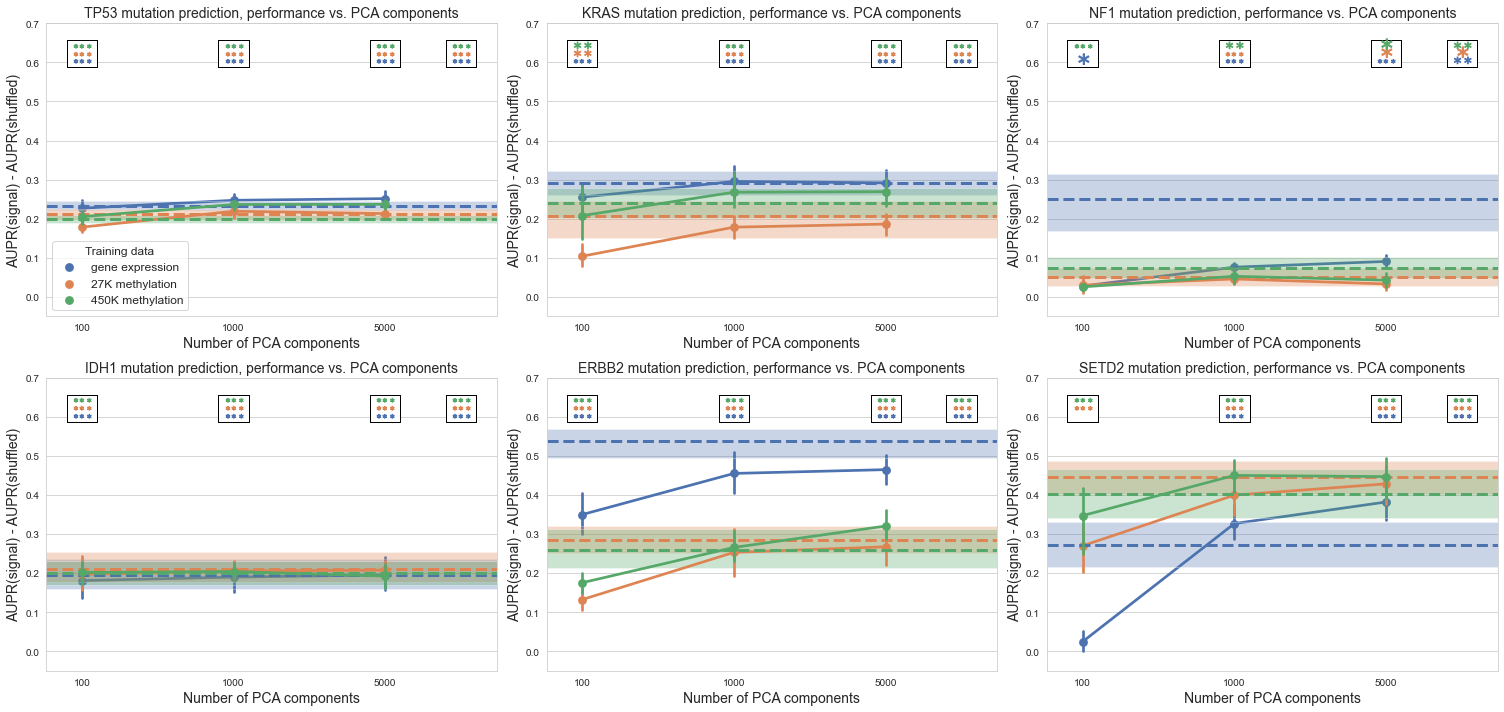

In [14]:
from matplotlib.patches import Rectangle

# look at some specific genes, we can do this using a line plot of 
# performance over increasing number of PCs
# dotted line = performance with raw features (genes/probes)
genes = ['TP53', 'KRAS', 'NF1', 'IDH1', 'ERBB2', 'SETD2']
sns.set({'figure.figsize': (21, 10)})
sns.set_style('whitegrid')
fig, axarr = plt.subplots(2, 3)

delta_metric = 'delta_{}'.format(plot_metric)

for ix, gene in enumerate(genes):
    ax = axarr[ix // 3, ix % 3]
    cmp_gene_df = cmp_compare_df[cmp_compare_df.gene == gene].copy()
    cmp_gene_df.training_data.replace(to_replace=train_names, inplace=True)
    g = sns.pointplot(data=cmp_gene_df, x='n_dims', y=delta_metric,
                      hue='training_data', ax=ax, legend=False)
    if ix != 0:
        ax.get_legend().remove()
    else:
        ax.legend(title='Training data', fontsize=12, title_fontsize=12,
                  loc='lower left')
        
    for color_ix, train_data in enumerate(raw_compare_df.training_data.unique()):
        raw_vals = raw_compare_df[
            (raw_compare_df.gene == gene) &
            (raw_compare_df.training_data == train_data)][delta_metric].values
        
        # get mean and plot as dotted line
        raw_mean = np.mean(raw_vals)
        ax.axhline(y=raw_mean, linestyle='--', linewidth=3, color=sns.color_palette()[color_ix])
        
        # get bootstrapped 95% CI, using seaborn method
        # plot as transparent shaded region
        raw_ci = sns.utils.ci(
            sns.algorithms.bootstrap(raw_vals,
                                     func=np.mean,
                                     n_boot=1000,
                                     units=None,
                                     seed=cfg.default_seed)
        )
        ax.axhspan(raw_ci[0], raw_ci[1], facecolor=sns.color_palette()[color_ix], alpha=0.3)
        
    def get_marker(p_val):
        if p_val > 0.05:
            return 0
        elif p_val > 0.01:
            return '$*$'
        elif p_val > 0.001:
            return '$**$'
        else:
            return '$***$'
        
    # add significance indicators
    for x, n_dims in enumerate([100, 1000, 5000, 'raw']):
        
        if n_dims == 'raw':
            p_vals = raw_compare_all_df[raw_compare_all_df.gene == gene]
        else:
            p_vals = cmp_compare_all_df[(cmp_compare_all_df.gene == gene) &
                                        (cmp_compare_all_df.n_dims == n_dims)]
            
        for train_ix, train_data in enumerate(sorted(p_vals.training_data.unique())):
            p_val = p_vals[p_vals.training_data == train_data].corr_pval.values[0]
            marker = get_marker(p_val)
            color = sns.color_palette()[train_ix]
            
            if marker != 0:
                # adjust the raw significance marker so it's off to the right a bit
                # put the other ones on top of the relevant n_dims
                x_loc = (x - 0.5 if n_dims == 'raw' else x)
                ax.scatter(x_loc, 0.6+(0.02*train_ix), marker=marker, color=color, s=300)
                
            # add a black rectangle around significance indicators
            ax.add_patch(
                Rectangle((x_loc-0.1, 0.5875), 0.2, 0.07,
                          edgecolor='black', fill=True, facecolor='white',
                          lw=1, zorder=0.6)
            )
        
    ax.set_title('{} mutation prediction, performance vs. PCA components'.format(gene), size=14)
    ax.set_xlabel('Number of PCA components', size=14)
    ax.set_ylabel('{}(signal) - {}(shuffled)'.format(
                      plot_metric.upper(), plot_metric.upper()),
                  size=14)
    raw_gene_df = raw_compare_df[raw_compare_df.gene == gene]
    ax.set_ylim(-0.05, 0.7)
    
plt.tight_layout()

if SAVE_FIGS:
    images_dir.mkdir(exist_ok=True)
    plt.savefig(images_dir / 'methylation_genes.svg', bbox_inches='tight')
    plt.savefig(images_dir / 'methylation_genes.png',
                dpi=300, bbox_inches='tight')

In [15]:
raw_compare_all_df['n_dims'] = 'raw'
compare_df = (
    pd.concat((raw_compare_all_df, cmp_compare_all_df))
      .sort_values(by=['training_data', 'n_dims'])
)
compare_df.training_data.replace(to_replace=train_names, inplace=True)
compare_df.head()

,gene,delta_mean,p_value,corr_pval,reject_null,training_data,nlog10_p,n_dims
190,PGR,-0.000923,0.969331,0.969331,False,gene expression,0.013528,100
128,JAK2,-0.002509,0.909110,0.912465,False,gene expression,0.039784,100
233,SETBP1,0.001646,0.903622,0.910315,False,gene expression,0.040808,100
72,ELF3,-0.004528,0.893066,0.903026,False,gene expression,0.044300,100
26,BCL9L,0.002571,0.877139,0.890230,False,gene expression,0.050498,100


(136,)
['IDH1' 'TERT' 'CCND3' 'PPP2R1A' 'LRP1B' 'NCOA2' 'STK11' 'AXIN1' 'ARNT'
 'KEAP1' 'APC' 'CUX1' 'MDM2' 'KAT6A' 'CDK4' 'DDR2' 'CASP8' 'TRRAP' 'ATRX'
 'WWTR1' 'FCRL4' 'NRAS' 'TSC1' 'BRAF' 'KMT2B' 'RB1' 'PPM1D' 'FCGR2B'
 'PIK3CA' 'FGFR1' 'CDKN2A' 'TP63' 'CCNE1' 'ERBB2' 'MSI2' 'NFE2L2' 'KRAS'
 'MECOM' 'FGFR3' 'HMGA2' 'RUNX1T1' 'GTF2I' 'SOX2' 'CTNNB1' 'CDH1' 'RAD21'
 'LPP' 'IKZF3' 'MAP3K13' 'BCL6' 'MYC' 'TP53' 'PTEN' 'EGFR' 'ETV5' 'NOTCH1'
 'ARID2' 'KDM6A' 'IL7R' 'ABL2' 'NTRK1' 'HEY1' 'JAK1' 'BAP1' 'MACF1'
 'FUBP1' 'NKX2-1' 'MYCL' 'MAP3K1' 'FBXW7' 'IKBKB' 'CACNA1A' 'EP300'
 'SMAD4' 'PBX1' 'BIRC3' 'NF1' 'GATA3' 'FOXA1' 'KMT2D' 'RARA' 'CDK6' 'SPOP'
 'SETD2' 'ARID1A' 'CIC' 'NSD1' 'PBRM1' 'CCND1' 'BCL9' 'KMT2C' 'ACVR2A'
 'PRKAR1A' 'KDM5A' 'RNF43' 'PREX2' 'H3F3A' 'ZFHX3' 'HRAS' 'MET' 'BRD4'
 'ZNF521' 'CTCF' 'DDX5' 'NCOR2' 'PTK6' 'CHD4' 'MDM4' 'NCOR1' 'SMARCA4'
 'ELK4' 'NIPBL' 'SF3B1' 'POLQ' 'CD79B' 'ERBB4' 'RAF1' 'FAT4' 'UBR5'
 'SOX17' 'JAK2' 'AKT2' 'BCL11A' 'DEK' 'XPO1' 'REL' 'FAT1' 'GNAS'

(-0.2, 0.8037285000000001)

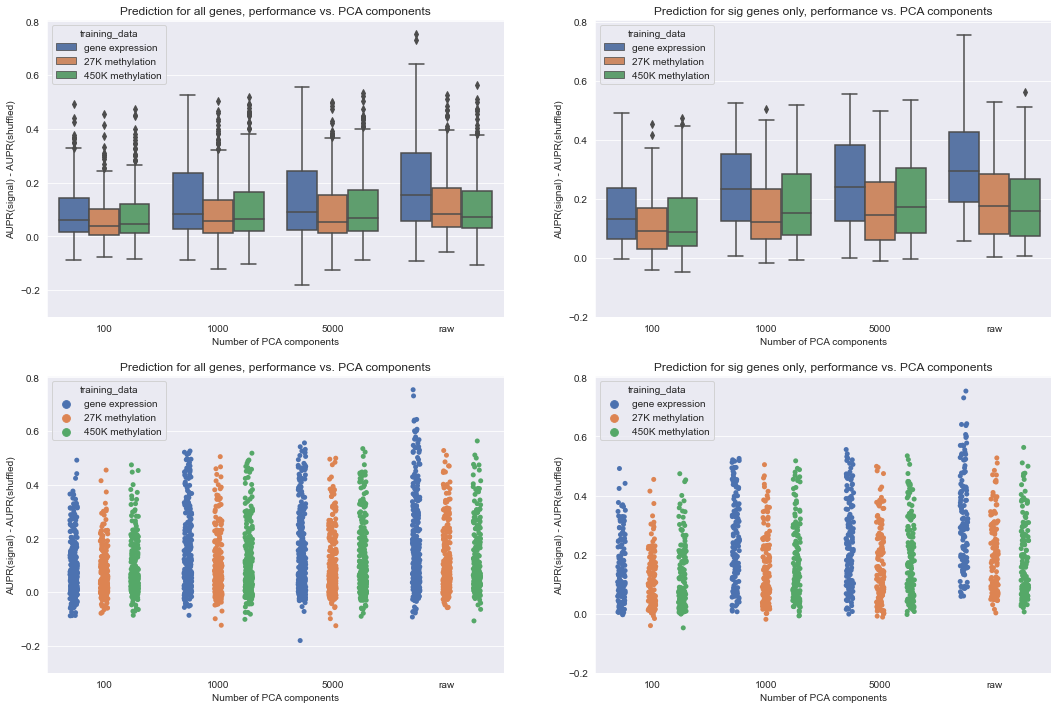

In [16]:
sns.set({'figure.figsize': (18, 12)})

fig, axarr = plt.subplots(2, 2)

# plot mean performance over all genes in Vogelstein dataset
ax = axarr[0, 0]
sns.boxplot(data=compare_df, x='n_dims', y='delta_mean', hue='training_data', ax=ax)
ax.set_title('Prediction for all genes, performance vs. PCA components')
ax.set_xlabel('Number of PCA components')
ax.set_ylabel('{}(signal) - {}(shuffled)'.format(
                  plot_metric.upper(), plot_metric.upper()))
ax.set_ylim(-0.3, max(compare_df.delta_mean + 0.05))


# plot mean performance for genes that are significant for at least one data type
ax = axarr[0, 1]
gene_list = compare_df[compare_df.reject_null == True].gene.unique()
print(gene_list.shape)
print(gene_list)
sns.boxplot(data=compare_df[compare_df.gene.isin(gene_list)], x='n_dims', y='delta_mean', hue='training_data', ax=ax)
ax.set_title('Prediction for sig genes only, performance vs. PCA components')
ax.set_xlabel('Number of PCA components')
ax.set_ylabel('{}(signal) - {}(shuffled)'.format(
                  plot_metric.upper(), plot_metric.upper()))
ax.set_ylim(-0.2, max(compare_df.delta_mean + 0.05))

ax = axarr[1, 0]
sns.stripplot(data=compare_df, x='n_dims', y='delta_mean', hue='training_data', dodge=True, ax=ax)
ax.set_title('Prediction for all genes, performance vs. PCA components')
ax.set_xlabel('Number of PCA components')
ax.set_ylabel('{}(signal) - {}(shuffled)'.format(
                  plot_metric.upper(), plot_metric.upper()))
ax.set_ylim(-0.3, max(compare_df.delta_mean + 0.05))

ax = axarr[1, 1]
sns.stripplot(data=compare_df[compare_df.gene.isin(gene_list)], x='n_dims', y='delta_mean',
              hue='training_data', dodge=True, ax=ax)
ax.set_title('Prediction for sig genes only, performance vs. PCA components')
ax.set_xlabel('Number of PCA components')
ax.set_ylabel('{}(signal) - {}(shuffled)'.format(
                  plot_metric.upper(), plot_metric.upper()))
ax.set_ylim(-0.2, max(compare_df.delta_mean + 0.05))

(136,)
['IDH1' 'TERT' 'CCND3' 'PPP2R1A' 'LRP1B' 'NCOA2' 'STK11' 'AXIN1' 'ARNT'
 'KEAP1' 'APC' 'CUX1' 'MDM2' 'KAT6A' 'CDK4' 'DDR2' 'CASP8' 'TRRAP' 'ATRX'
 'WWTR1' 'FCRL4' 'NRAS' 'TSC1' 'BRAF' 'KMT2B' 'RB1' 'PPM1D' 'FCGR2B'
 'PIK3CA' 'FGFR1' 'CDKN2A' 'TP63' 'CCNE1' 'ERBB2' 'MSI2' 'NFE2L2' 'KRAS'
 'MECOM' 'FGFR3' 'HMGA2' 'RUNX1T1' 'GTF2I' 'SOX2' 'CTNNB1' 'CDH1' 'RAD21'
 'LPP' 'IKZF3' 'MAP3K13' 'BCL6' 'MYC' 'TP53' 'PTEN' 'EGFR' 'ETV5' 'NOTCH1'
 'ARID2' 'KDM6A' 'IL7R' 'ABL2' 'NTRK1' 'HEY1' 'JAK1' 'BAP1' 'MACF1'
 'FUBP1' 'NKX2-1' 'MYCL' 'MAP3K1' 'FBXW7' 'IKBKB' 'CACNA1A' 'EP300'
 'SMAD4' 'PBX1' 'BIRC3' 'NF1' 'GATA3' 'FOXA1' 'KMT2D' 'RARA' 'CDK6' 'SPOP'
 'SETD2' 'ARID1A' 'CIC' 'NSD1' 'PBRM1' 'CCND1' 'BCL9' 'KMT2C' 'ACVR2A'
 'PRKAR1A' 'KDM5A' 'RNF43' 'PREX2' 'H3F3A' 'ZFHX3' 'HRAS' 'MET' 'BRD4'
 'ZNF521' 'CTCF' 'DDX5' 'NCOR2' 'PTK6' 'CHD4' 'MDM4' 'NCOR1' 'SMARCA4'
 'ELK4' 'NIPBL' 'SF3B1' 'POLQ' 'CD79B' 'ERBB4' 'RAF1' 'FAT4' 'UBR5'
 'SOX17' 'JAK2' 'AKT2' 'BCL11A' 'DEK' 'XPO1' 'REL' 'FAT1' 'GNAS'

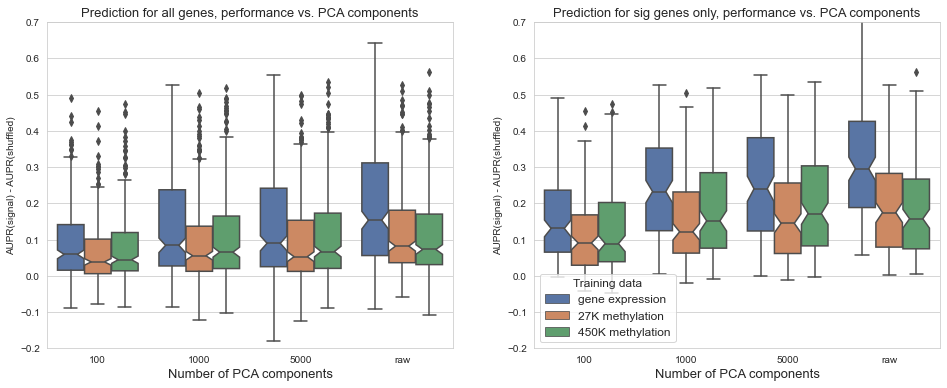

In [17]:
# same plot but only the first row (box plots)
sns.set({'figure.figsize': (16, 6)})
sns.set_style('whitegrid')

fig, axarr = plt.subplots(1, 2)

# plot mean performance over all genes in Vogelstein dataset
ax = axarr[0]
sns.boxplot(data=compare_df, x='n_dims', y='delta_mean', hue='training_data', notch=True, ax=ax)
ax.get_legend().remove()
ax.set_title('Prediction for all genes, performance vs. PCA components', size=13)
ax.set_xlabel('Number of PCA components', size=13)
ax.set_ylabel('{}(signal) - {}(shuffled)'.format(
                  plot_metric.upper(), plot_metric.upper()))
ax.set_ylim(-0.2, 0.7)


# plot mean performance for genes that are significant for at least one data type
ax = axarr[1]
gene_list = compare_df[compare_df.reject_null == True].gene.unique()
print(gene_list.shape)
print(gene_list)
sns.boxplot(data=compare_df[compare_df.gene.isin(gene_list)], x='n_dims', y='delta_mean',
            hue='training_data', notch=True, ax=ax)
ax.legend(title='Training data', fontsize=12, title_fontsize=12,
          loc='lower left')
ax.set_title('Prediction for sig genes only, performance vs. PCA components', size=13)
ax.set_xlabel('Number of PCA components', size=13)
ax.set_ylabel('{}(signal) - {}(shuffled)'.format(
                  plot_metric.upper(), plot_metric.upper()))
ax.set_ylim(-0.2, 0.7)

if SAVE_FIGS:
    plt.savefig(images_dir / 'methylation_compress_boxes.svg', bbox_inches='tight')
    plt.savefig(images_dir / 'methylation_compress_boxes.png',
                dpi=300, bbox_inches='tight')